# Fit emimTF2N data

EoS: PR

Parameter T dependence: Linear

N (total fitting parameters): 4

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions import linear

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('r125_emimtf2n_full.csv')
data_subset = pd.read_csv('r125_emimtf2n_subset.csv')

## Load Configuration + Check DOF

In [3]:
from hfc125_emimtf2n_PR import configuration 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

In [24]:
parameters, obj_value, a = linear(data_subset, configuration, 'R125', 'emimTf2N', "x_R125", "x_emimTf2N", 
    init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
    init_kappa_2_1A = 0.001, init_kappa_1_2A = -0.01,
    init_kappa_2_1B = -0.01, init_kappa_1_2B = -0.01, eps = 0.1, scaling_fac = 1e-9)

2022-04-04 20:04:13 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-04 20:04:14 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-04 20:04:14 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-04 20:04:14 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-04 20:04:15 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-04 20:04:15 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-04 20:04:15 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-04 20:04:16 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-04 20:04:16 [INFO] idaes

    Please recompile / update your pynumero_ASL library.
The SSE at the optimal solution is 0.117352

The values for the parameters are as follows:
fs.properties.PR_kappa_A[R125,emimTf2N] = -0.05238792203910701
fs.properties.PR_kappa_A[emimTf2N,R125] = -0.10286544415484122
fs.properties.PR_kappa_B[R125,emimTf2N] = 0.032664230572416124
fs.properties.PR_kappa_B[emimTf2N,R125] = 0.04219896599033475
covariance_matrix                                          fs.properties.PR_kappa_A[R125,emimTf2N]  \
fs.properties.PR_kappa_A[R125,emimTf2N]                                 0.000098   
fs.properties.PR_kappa_A[emimTf2N,R125]                                 0.000811   
fs.properties.PR_kappa_B[R125,emimTf2N]                                -0.000091   
fs.properties.PR_kappa_B[emimTf2N,R125]                                -0.000776   

                                         fs.properties.PR_kappa_A[emimTf2N,R125]  \
fs.properties.PR_kappa_A[R125,emimTf2N]                                 0.0008

/Users/bridgettebefort/opt/anaconda3/envs/idaes-pse-dev/lib/python3.9/site-packages/pyomo/contrib/interior_point/interface.py:418: RuntimeWarning: divide by zero encountered in true_divide
  data = (duals_primals_lb/(primals - self._nlp.primals_lb()) +


In [25]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.11735158452753446


In [26]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[ 9.81317817e-05  8.11102889e-04 -9.07602965e-05 -7.76123038e-04]
 [ 8.11102889e-04  2.66089338e-02 -8.59875059e-04 -2.75275644e-02]
 [-9.07602965e-05 -8.59875059e-04  8.49454632e-05  8.37388067e-04]
 [-7.76123038e-04 -2.75275644e-02  8.37388067e-04  2.85755266e-02]]


In [27]:
np.savetxt('Data/Covariance/PR_Cov_4parameter.csv',cov,delimiter=',')

## Apply Parameters + Plot

In [28]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [29]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa_A['R125','emimTf2N'] = parameters['fs.properties.PR_kappa_A[R125,emimTf2N]']
m.fs.properties.PR_kappa_A['emimTf2N','R125'] = parameters['fs.properties.PR_kappa_A[emimTf2N,R125]']
m.fs.properties.PR_kappa_B['R125','emimTf2N'] = parameters['fs.properties.PR_kappa_B[R125,emimTf2N]']
m.fs.properties.PR_kappa_B['emimTf2N','R125'] = parameters['fs.properties.PR_kappa_B[emimTf2N,R125]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R125_x = np.zeros((len(data_full)))
P = np.zeros((len(data_full)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_full)):
    m.fs.liq = data_full["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_full["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data_full["x_R125"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_full["x_R125"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data_full["x_emimTf2N"].iloc[i])
        R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.992
0.915
0.832
0.75
0.669
0.587
0.504
0.417
0.319
0.994
0.945
0.891
0.839
0.787
0.733
0.683
0.578
0.479
0.996
0.97
0.941
0.912
0.883
0.848
0.824
0.772
0.715
0.996
0.982
0.966
0.95
0.926
0.903
0.895
0.86
0.829


In [30]:
fitted_data = pd.DataFrame(data=[R125_x,P/1e6])
fitted_data = fitted_data.T
fitted_data.columns = ['R125_x','P, MPa']
fitted_data.to_csv('Data/Fits/PR_FittedData_4parameter.csv')

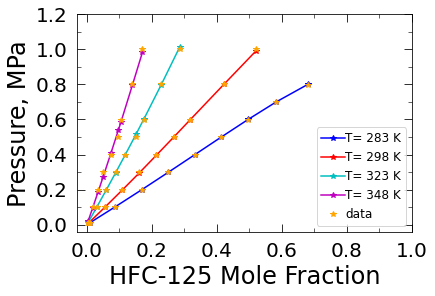

In [31]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

fig, ax = plt.subplots()

ax.plot(R125_x[0:9],P1[0:9],"b*-",label="T= 283 K")  
ax.plot(R125_x[9:18],P1[9:18],"r*-",label="T= 298 K") 
ax.plot(R125_x[18:27],P1[18:27],"c*-",label="T= 323 K") 
ax.plot(R125_x[27:],P1[27:],"m-*",label="T= 348 K")
ax.plot(data_full["x_R125"],data_full["pressure"]/1e6,"*",color='orange',label="data")  

# plt.title('Isotherm R32-[emim][TF2N]')
ax.set_ylabel('Pressure, MPa',fontsize=24)
ax.set_xlabel('HFC-125 Mole Fraction',fontsize=24)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9],minor=True)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1],minor=True)

ax.tick_params("both", direction="in", which="both", length=4, labelsize=20, pad=10)
ax.tick_params("both", which="major", length=8)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(fontsize=12, handletextpad=0.00, loc="lower right")#, bbox_to_anchor=(1, 0.5))
fig.savefig('R125-emimTF2N-linTdep.pdf',bbox_inches='tight')
plt.show()

### Print Eigvals, Eigvectors

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals > 0, their eigvecs indicate directions of un-identifiability.

In [32]:
eigvals, eigvecs = np.linalg.eig(cov)

In [33]:
eigvals

array([5.51863915e-02, 1.63071137e-04, 8.52017113e-08, 1.79898739e-05])

In [34]:
eigvecs

array([[ 0.02038906,  0.6724605 ,  0.68488713, -0.27984064],
       [ 0.69408426,  0.30454483, -0.05407224,  0.65005822],
       [-0.02179595, -0.58791957,  0.72457673,  0.35897643],
       [-0.71927482,  0.33075657, -0.05472085,  0.60848127]])

In [35]:
np.savetxt('Data/EigenAnalysis/PR_vals_4parameter.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/PR_vecs_4parameter.csv',eigvecs,delimiter=',')

Conclusion: Full identifiable because all eigvals ~ 0

## FIM with Enthalpy of Vaporization (and Pressure)

### Step 1: Perturb Parameters, Calculate Enthalpy of Vaporization

1. Perturb Parameters: stepsize = 0.001

2. Holding all other parameters constant, calculate new pressure predictions at different temps, compositions 

*T = (T1=298, T2=323)

*x = (0.01,0.2,0.325,0.4)

*Pguess comes from data_full

3. Save P, Use Clausius Clapeyron to calculate enthvap

In [ ]:
h = 0.001
kR32_emimTF2N_A_plus = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'] + h
kR32_emimTF2N_A_minus = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'] - h
kemimTF2N_R32_A_plus = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'] + h
kemimTF2N_R32_A_minus = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'] - h
kR32_emimTF2N_B_plus = parameters['fs.properties.PR_kappa_B[R32,emimTf2N]'] + h
kR32_emimTF2N_B_minus = parameters['fs.properties.PR_kappa_B[R32,emimTf2N]'] - h
kemimTF2N_R32_B_plus = parameters['fs.properties.PR_kappa_B[emimTf2N,R32]'] + h
kemimTF2N_R32_B_minus = parameters['fs.properties.PR_kappa_B[emimTf2N,R32]'] - h

In [ ]:
data = np.array([[kR32_emimTF2N_A_plus,parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'],parameters['fs.properties.PR_kappa_B[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']],
                [kR32_emimTF2N_A_minus,parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'],parameters['fs.properties.PR_kappa_B[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']],
                [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],kemimTF2N_R32_A_plus,parameters['fs.properties.PR_kappa_B[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']],
               [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],kemimTF2N_R32_A_minus,parameters['fs.properties.PR_kappa_B[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']],
                [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'],kR32_emimTF2N_B_plus,parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']],
                 [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'],kR32_emimTF2N_B_minus,parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']],
                 [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'],parameters['fs.properties.PR_kappa_B[R32,emimTf2N]'],kemimTF2N_R32_B_plus],
                 [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'],parameters['fs.properties.PR_kappa_B[R32,emimTf2N]'],kemimTF2N_R32_B_minus]])

In [ ]:
perturbed_params = pd.DataFrame(data=data,columns=['kR32_emimTF2N_A','kemimTF2N_R32_A','kR32_emimTF2N_B','kemimTF2N_R32_B'])
perturbed_params

In [ ]:
x = [0.01,0.2,0.325,0.4]
temps_298 = [298.15,298.15,298.15,298.15]
pguess_298 = [9600,250000,399400,549000]
temps_323 = [323.15,323.15,323.15,323.15]
pguess_323 = [20400,400100,700300,1000000]

In [ ]:
test_298 = pd.DataFrame()
test_298['temperature'] = temps_298
test_298['pressure'] = pguess_298
test_298['x_R32'] = x
test_298['x_emimTf2N'] = 1-test_298['x_R32']
# test_298

In [ ]:
test_323 = pd.DataFrame()
test_323['temperature'] = temps_323
test_323['pressure'] = pguess_323
test_323['x_R32'] = x
test_323['x_emimTf2N'] = 1-test_323['x_R32']
# test_323

In [ ]:
test_data = pd.concat([test_298,test_323],ignore_index=True)

In [ ]:
# Loop through test values

R32_x = np.zeros((len(perturbed_params),len(test_data)))
P = np.zeros((len(perturbed_params),len(test_data)))

for j in range(len(perturbed_params)):

    m = ConcreteModel()

    m.fs = FlowsheetBlock(default={"dynamic": False})

    m.fs.properties = GenericParameterBlock(default=configuration)

    m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

    m.fs.F101.inlet.flow_mol.fix(1)
    m.fs.F101.inlet.temperature.fix(323.15)
    m.fs.F101.inlet.pressure.fix(399800)
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)
    
    m.fs.properties.PR_kappa_A['R32','emimTf2N'] = perturbed_params['kR32_emimTF2N_A'][j]
    m.fs.properties.PR_kappa_A['emimTf2N','R32'] = perturbed_params['kemimTF2N_R32_A'][j]
    m.fs.properties.PR_kappa_B['R32','emimTf2N'] = perturbed_params['kR32_emimTF2N_B'][j]
    m.fs.properties.PR_kappa_B['emimTf2N','R32'] = perturbed_params['kemimTF2N_R32_B'][j]
    

    # Initialize the flash unit
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

    # Fix the state variables on the state block
    # m.fs.F101.inlet.pressure.unfix()
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(test_data)):
        m.fs.liq = test_data["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.temperature.fix(float(test_data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(test_data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(test_data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(test_data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(test_data["temperature"].iloc[i]))

    #     DOF_final = degrees_of_freedom(m)
    #     print("The final DOF is {0}".format(DOF_final))
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print(test_data["x_emimTf2N"].iloc[i])
            R32_x[j,i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32'])
            P[j,i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')

In [ ]:
test_data['P_kR32_emimTF2N_A_plus'] = P[0]
test_data['P_kR32_emimTF2N_A_minus'] = P[1]
test_data['P_kemimTF2N_R32_A_plus'] = P[2]
test_data['P_kemimTF2N_R32_A_minus'] = P[3]
test_data['P_kR32_emimTF2N_B_plus'] = P[4]
test_data['P_kR32_emimTF2N_B_minus'] = P[5]
test_data['P_kemimTF2N_R32_B_plus'] = P[6]
test_data['P_kemimTF2N_R32_B_minus'] = P[7]

In [ ]:
grad_P = test_data

In [ ]:
test_data_298 = test_data[test_data['temperature']==298.15]
test_data_323 = test_data[test_data['temperature']==323.15].reset_index()

In [ ]:
R = 8.314 #J/mol-K
hvap_calc_kR32_emimTF2N_A_plus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kR32_emimTF2N_A_plus'][i]
    P1 = test_data_298['P_kR32_emimTF2N_A_plus'][i]
    hvap_calc_kR32_emimTF2N_A_plus.append(np.log(P2/P1)*R/(1/T2-1/T1))

hvap_calc_kR32_emimTF2N_A_minus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kR32_emimTF2N_A_minus'][i]
    P1 = test_data_298['P_kR32_emimTF2N_A_minus'][i]
    hvap_calc_kR32_emimTF2N_A_minus.append(np.log(P2/P1)*R/(1/T2-1/T1))
    
hvap_calc_kemimTF2N_R32_A_plus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kemimTF2N_R32_A_plus'][i]
    P1 = test_data_298['P_kemimTF2N_R32_A_plus'][i]
    hvap_calc_kemimTF2N_R32_A_plus.append(np.log(P2/P1)*R/(1/T2-1/T1))
    
hvap_calc_kemimTF2N_R32_A_minus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kemimTF2N_R32_A_minus'][i]
    P1 = test_data_298['P_kemimTF2N_R32_A_minus'][i]
    hvap_calc_kemimTF2N_R32_A_minus.append(np.log(P2/P1)*R/(1/T2-1/T1))
    
hvap_calc_kR32_emimTF2N_B_plus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kR32_emimTF2N_B_plus'][i]
    P1 = test_data_298['P_kR32_emimTF2N_B_plus'][i]
    hvap_calc_kR32_emimTF2N_B_plus.append(np.log(P2/P1)*R/(1/T2-1/T1))

hvap_calc_kR32_emimTF2N_B_minus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kR32_emimTF2N_B_minus'][i]
    P1 = test_data_298['P_kR32_emimTF2N_B_minus'][i]
    hvap_calc_kR32_emimTF2N_B_minus.append(np.log(P2/P1)*R/(1/T2-1/T1))
    
hvap_calc_kemimTF2N_R32_B_plus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kemimTF2N_R32_B_plus'][i]
    P1 = test_data_298['P_kemimTF2N_R32_B_plus'][i]
    hvap_calc_kemimTF2N_R32_B_plus.append(np.log(P2/P1)*R/(1/T2-1/T1))
    
hvap_calc_kemimTF2N_R32_B_minus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kemimTF2N_R32_B_minus'][i]
    P1 = test_data_298['P_kemimTF2N_R32_B_minus'][i]
    hvap_calc_kemimTF2N_R32_B_minus.append(np.log(P2/P1)*R/(1/T2-1/T1))

In [ ]:
hvap = pd.DataFrame()
hvap['x_R32'] = x
hvap['hvap_kR32_emimTF2N_A_plus'] = hvap_calc_kR32_emimTF2N_A_plus
hvap['hvap_kR32_emimTF2N_A_minus'] = hvap_calc_kR32_emimTF2N_A_minus
hvap['hvap_kemimTF2N_R32_A_plus'] = hvap_calc_kemimTF2N_R32_A_plus
hvap['hvap_kemimTF2N_R32_A_minus'] = hvap_calc_kemimTF2N_R32_A_minus
hvap['hvap_kR32_emimTF2N_B_plus'] = hvap_calc_kR32_emimTF2N_B_plus
hvap['hvap_kR32_emimTF2N_B_minus'] = hvap_calc_kR32_emimTF2N_B_minus
hvap['hvap_kemimTF2N_R32_B_plus'] = hvap_calc_kemimTF2N_R32_B_plus
hvap['hvap_kemimTF2N_R32_B_minus'] = hvap_calc_kemimTF2N_R32_B_minus

In [ ]:
hvap

### Step 2: Calculate Gradient wrt each param at each concentration

In [ ]:
grad_kR32_emimTF2N_A = (hvap['hvap_kR32_emimTF2N_A_plus'] - hvap['hvap_kR32_emimTF2N_A_minus'])/(2*h)
grad_kemimTF2N_R32_A = (hvap['hvap_kemimTF2N_R32_A_plus'] - hvap['hvap_kemimTF2N_R32_A_minus'])/(2*h)
grad_kR32_emimTF2N_B = (hvap['hvap_kR32_emimTF2N_B_plus'] - hvap['hvap_kR32_emimTF2N_B_minus'])/(2*h)
grad_kemimTF2N_R32_B = (hvap['hvap_kemimTF2N_R32_B_plus'] - hvap['hvap_kemimTF2N_R32_B_minus'])/(2*h)

In [ ]:
grad_P['kR32_emimTF2N_A'] = (grad_P['P_kR32_emimTF2N_A_plus'] - grad_P['P_kR32_emimTF2N_A_minus'])/(2*h)
grad_P['kemimTF2N_R32_A'] = (grad_P['P_kemimTF2N_R32_A_plus'] - grad_P['P_kemimTF2N_R32_A_minus'])/(2*h)
grad_P['kR32_emimTF2N_B'] = (grad_P['P_kR32_emimTF2N_B_plus'] - grad_P['P_kR32_emimTF2N_B_minus'])/(2*h)
grad_P['kemimTF2N_R32_B'] = (grad_P['P_kemimTF2N_R32_B_plus'] - grad_P['P_kemimTF2N_R32_B_minus'])/(2*h)

### Step 3: Build Jacobian and FIM

Rows: enthvap @ 4 concentrations; or pressure @ 4 concentrations, 2 temps

Columns: parameters (4)

In [ ]:
J_df = pd.DataFrame()
J_df['kR32_emimTF2N_A'] = grad_kR32_emimTF2N_A
J_df['kemimTF2N_R32_A'] = grad_kemimTF2N_R32_A
J_df['kR32_emimTF2N_B'] = grad_kR32_emimTF2N_B
J_df['kemimTF2N_R32_B'] = grad_kemimTF2N_R32_B

In [ ]:
J = J_df.to_numpy()
Jtrans = np.transpose(J)

In [ ]:
FIM = np.dot(Jtrans,J)

In [ ]:
FIM

In [ ]:
J_df_P = pd.DataFrame()
J_df_P['kR32_emimTF2N_A'] = grad_P['kR32_emimTF2N_A']
J_df_P['kemimTF2N_R32_A'] = grad_P['kemimTF2N_R32_A']
J_df_P['kR32_emimTF2N_B'] = grad_P['kR32_emimTF2N_B']
J_df_P['kemimTF2N_R32_B'] = grad_P['kemimTF2N_R32_B']

In [ ]:
J_P = J_df_P.to_numpy()
J_Ptrans = np.transpose(J_P)

In [ ]:
FIM_P = np.dot(J_Ptrans,J_P)

In [ ]:
FIM_P

### Step 4: Find Eigenvalues, Eigenvectors

**Enthalpy of Vaporization**

In [ ]:
eigvals, eigvecs = np.linalg.eig(FIM)

In [ ]:
eigvals

In [ ]:
eigvecs

There is 1 eigval < 0, indicating 1 unidentifiable direction. Its corresponding eigenvector has the highest values in the last two parameters, indicating these would be the directions of unidentifiability.

**Pressure**

In [ ]:
eigvals_P, eigvecs_P = np.linalg.eig(FIM_P)

In [ ]:
eigvals_P

In [ ]:
eigvecs_P

All eigvals >> 0, assuming these 4 parameters are identifiable with the given T,x,P data

## AIC Value

See https://docs.google.com/document/d/1um0r2XK4ldjjy2colOqaZsEM3wIzGD6l_3B8gnpnI2I/edit# for equations

### Calculate MLE

In [ ]:
### Define calc model P function

def calcPmod(theta,data):
    '''
    Arguments:
    theta - list of BIPs
    data - data needed to run the model
    
    Returns
    Pmod - list of calculated pressures
    '''
    
    m = ConcreteModel()

    m.fs = FlowsheetBlock(default={"dynamic": False})

    m.fs.properties = GenericParameterBlock(default=configuration)

    m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

    m.fs.F101.inlet.flow_mol.fix(1)
    m.fs.F101.inlet.temperature.fix(323.15)
    m.fs.F101.inlet.pressure.fix(399800)
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

    m.fs.properties.PR_kappa_A['R32','emimTf2N'] = theta[0]
    m.fs.properties.PR_kappa_A['emimTf2N','R32'] = theta[1]
    m.fs.properties.PR_kappa_B['R32','emimTf2N'] = theta[2]
    m.fs.properties.PR_kappa_B['emimTf2N','R32'] = theta[3]

    # Initialize the flash unit
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

    # Fix the state variables on the state block
    # m.fs.F101.inlet.pressure.unfix()
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

    R32_x = np.zeros((len(data)))
    P = np.zeros((len(data)))

    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(data)):
        m.fs.liq = data["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))

    #     DOF_final = degrees_of_freedom(m)
    #     print("The final DOF is {0}".format(DOF_final))
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
#             print(data["x_emimTf2N"].iloc[i])
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    Pmod = P
    
    return Pmod

In [ ]:
### Define function to calculate SSR
def res(theta,data,Pexp):
    '''
    Arguments:
    theta - list of BIPs
    data - data needed to run the model
    Pexp - list of experimental pressure data
    
    Returns:
    residual between model and exp (note, this will be large because of units of P)
    '''
    
    #Calculate model P
    Pmod = calcPmod(theta,data)
    
    return Pexp - Pmod

In [ ]:
theta_guess = [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'],parameters['fs.properties.PR_kappa_B[R32,emimTf2N]'],parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']]
Pexp = data_subset['pressure'].values.tolist()
n = 4
bnds = ([-20,-20,-20,-20],[20,20,20,20])

In [ ]:
### solve
sol = scipy.optimize.least_squares(res, theta_guess, method='trf', args=(data_subset,Pexp),bounds=bnds)

In [ ]:
theta_hat = sol.x
theta_hat

In [ ]:
def SSR(theta,data,Pexp):
    '''
    Arguments:
    theta - list of BIPs
    data - data needed to run the model
    Pexp - list of experimental pressure data
    
    Returns:
    SSR - sum of residuals squared
    '''
    
    #Calculate model P
    Pmod = calcPmod(theta,data)
    
    #Calculate residual squared
    res = (Pexp - Pmod)**2
    
    #Sum residuals squared
    SSR = np.sum(res)
      
    return SSR

In [ ]:
SSR = SSR(theta_hat,data_subset,Pexp)
SSR

In [ ]:
sigma_sq = SSR/n
sigma_sq

In [ ]:
L = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq) - 1/(2*sigma_sq)*SSR
L

In [ ]:
AIC = 2*n - 2*L
AIC

Other AIC - using SSR calculated in above parameter fitting

In [36]:
n=4

In [37]:
SSR_other = obj_value

In [38]:
sigma_sq_other = SSR_other/n
sigma_sq_other

0.029337896131883614

In [39]:
L_other = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq_other) - 1/(2*sigma_sq_other)*SSR_other
L_other

1.3819962978175129

In [40]:
AIC_other = 2*n - 2*L_other
AIC_other

5.236007404364974

In [41]:
AIC_data = pd.DataFrame(data=[n,obj_value,AIC_other])
AIC_data = AIC_data.T
AIC_data.columns = ['n','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/PR_AIC_4parameter.csv')